# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import lightgbm as lgb
from datetime import date, timedelta
import os
from local_utils import *  # Ваши вспомогательные функции

# ======================
# 1. Конфигурация
# ======================
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"
test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_start_date = date(2023, 7, 1)  # Год данных для обучения

# ======================
# 2. Загрузка данных
# ======================
print("Загрузка данных...")
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
product_information = pl.read_csv(os.path.join(data_path, 'cluster_product_information.csv'), ignore_errors=True)
test_users = pl.read_csv(os.path.join(data_path, 'test_users.csv'))

# ======================
# 3. Подготовка целевой переменной (обучение)
# ======================
print("Подготовка целевой переменной...")
train_val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= train_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)


Загрузка данных...
Подготовка целевой переменной...


In [2]:
# ======================
# 4. Создание признаков
# ======================
print("Создание признаков...")
actions_aggs = {}
actions_id_to_suf = {1: "click", 2: "favorite", 3: "order", 5: "to_cart"}
numeric_features = []

def create_features(data, end_date, prefix=''):
    features = {}
    
    # 4.1. Признаки из actions_history
    for id_, suf in actions_id_to_suf.items():
        aggs = (
            data
            .filter(pl.col('timestamp').dt.date() <= end_date)
            .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30*4))
            .filter(pl.col('action_type_id') == id_)
            .join(product_information.select('product_id', 'discount_price'), on='product_id')
            .group_by('user_id')
            .agg(
                pl.count('product_id').cast(pl.Int32).alias(f'{prefix}num_products_{suf}'),
                pl.sum('discount_price').cast(pl.Float32).alias(f'{prefix}sum_discount_price_{suf}'),
                pl.max('discount_price').cast(pl.Float32).alias(f'{prefix}max_discount_price_{suf}'),
                (end_date - pl.col('timestamp').max()).dt.total_days().cast(pl.Int32).alias(f'{prefix}days_since_last_{suf}'),
                (end_date - pl.col('timestamp').min()).dt.total_days().cast(pl.Int32).alias(f'{prefix}days_since_first_{suf}')
            )
        )
        features[id_] = aggs
    
    # 4.2. Признаки из search_history
    cluster_counts = (
        search_history
        .filter(pl.col('action_type_id') == 4)
        .filter(pl.col('timestamp').dt.date() <= end_date)
        .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30*5))
        .group_by('user_id')
        .agg(pl.col('cluster').value_counts().alias('cluster_counts'))
        .explode('cluster_counts')
        .with_columns(
            pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
            pl.col('cluster_counts').struct.field('count').alias('cluster_count')
        )
        .group_by('user_id')
        .agg(
            pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias(f'{prefix}top3_search_clusters'),
            pl.col('cluster_count').sort(descending=True).head(3).alias(f'{prefix}top3_search_counts')
        )
    )

    search_aggs = (
        search_history
        .filter(pl.col('action_type_id') == 4)
        .filter(pl.col('timestamp').dt.date() <= end_date)
        .filter(pl.col('timestamp').dt.date() >= end_date - timedelta(days=30*5))
        .group_by('user_id')
        .agg(
            pl.count('search_query').cast(pl.Int32).alias(f'{prefix}num_search'),
            pl.col('search_query').n_unique().alias(f'{prefix}unique_search_queries'),
            # ... остальные агрегации как в вашем коде ...
        )
        .join(cluster_counts, on='user_id', how='left')
    )
    features[4] = search_aggs
    
    return features

# Создаем признаки для обучения
train_features = create_features(actions_history, val_end_date)

Создание признаков...


In [5]:
# ======================
# 5. Подготовка данных для обучения
# ======================
print("Подготовка данных для обучения...")
df_train = train_val_target
for _, feature_df in train_features.items():
    df_train = df_train.join(feature_df, on='user_id', how='left')

# Конвертируем в pandas и применяем преобразования
df_train_pd = df_train.to_pandas()

# Логарифмирование признаков
columns_to_log = [
    'num_products_click', 'sum_discount_price_click', 'max_discount_price_click',
    # ... все остальные колонки для логарифмирования ...
]
df_train_pd = apply_log_transform(df_train_pd, columns_to_log, drop_original=False)

# Приведение типов
for col in df_train_pd.select_dtypes(include=['float64', 'int64']).columns:
    df_train_pd[col] = df_train_pd[col].astype('float32')

# Удаление временных колонок и определение фичей
cols = list(set(df_train_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'top3_search_clusters', 'top3_search_counts'})


Подготовка данных для обучения...


In [23]:
# ======================
# 6. Обучение модели
# ======================
print("Обучение модели...")
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 100,
    'num_iterations': 700,
    'verbose': 1,
    'importance_type': 'split'
}

model = lgb.LGBMClassifier(**params)
model.fit(
    df_train_pd[cols],
    df_train_pd['target'],
)

'''# Разделяем данные на тренировочные и валидационные
from sklearn.model_selection import train_test_split

X = df_train_pd[cols]
y = df_train_pd['target']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# Параметры модели
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 100,
    'num_iterations': 700,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'importance_type': 'split'
}

# Обучение с валидационным набором
model = lgb.LGBMClassifier(**params)
model.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=60),
        lgb.log_evaluation(50)
    ]
)'''


Обучение модели...
[LightGBM] [Info] Number of positive: 1336617, number of negative: 3887436
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.109432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5150
[LightGBM] [Info] Number of data points in the train set: 5224053, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.255858 -> initscore=-1.067608
[LightGBM] [Info] Start training from score -1.067608


"# Разделяем данные на тренировочные и валидационные\nfrom sklearn.model_selection import train_test_split\n\nX = df_train_pd[cols]\ny = df_train_pd['target']\n\nX_train, X_val, y_train, y_val = train_test_split(\n    X, y, \n    test_size=0.2, \n    random_state=42,\n    stratify=y\n)\n\n# Параметры модели\nparams = {\n    'objective': 'binary',\n    'metric': 'auc',\n    'learning_rate': 0.01,\n    'max_depth': 100,\n    'num_iterations': 700,\n    'early_stopping_rounds': 60,\n    'verbose': 1,\n    'importance_type': 'split'\n}\n\n# Обучение с валидационным набором\nmodel = lgb.LGBMClassifier(**params)\nmodel.fit(\n    X_train,\n    y_train,\n    eval_set=[(X_val, y_val)],\n    callbacks=[\n        lgb.early_stopping(stopping_rounds=60),\n        lgb.log_evaluation(50)\n    ]\n)"

In [ ]:
'''from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
import numpy as np

# Параметры модели
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 100,
    'n_estimators': 700,
    'verbose': -1,
    'importance_type': 'split'
}

# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []
models = []

X = df_train_pd[cols]
y = df_train_pd['target']


for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print(f"\nFold {fold + 1}")
    
    # Разбиение данных
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Обучение с ранней остановкой
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=60, verbose=False),
            lgb.log_evaluation(50)
        ]
    )
    
    # Сохраняем модель и оценку
    models.append(model)
    score = model.best_score_['valid_0']['auc']
    cv_scores.append(score)
    print(f"Fold AUC: {score:.4f}")

# Финальная модель на всех данных
best_n_estimators = int(np.mean([m.best_iteration_ for m in models]))
final_model = lgb.LGBMClassifier(**{**params, 'n_estimators': best_n_estimators})
final_model.fit(X, y)

print(f"\nMean CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
print(f"Final model trees: {best_n_estimators}")'''

feature_importance: [1443  182  700  738  639 1644 3151  425  640    0    0 1496 1502    0
 1342  957    0  372  198  662  205    0    0 4328  376] 



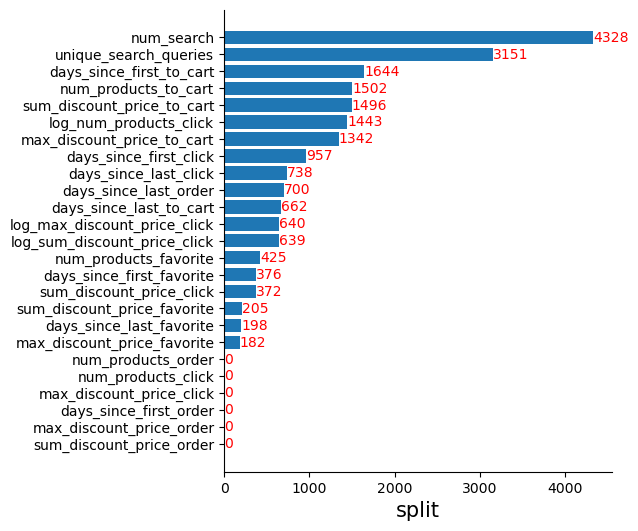

In [25]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [27]:
# ======================
# 7. Подготовка тестовых данных
# ======================
print("Подготовка тестовых данных...")
test_features = create_features(actions_history, test_start_date, prefix='test_')

df_test = test_users
for _, feature_df in test_features.items():
    df_test = df_test.join(feature_df, on='user_id', how='left')

df_test_pd = df_test.to_pandas()

# Применяем те же преобразования
df_test_pd = apply_log_transform(df_test_pd, columns_to_log, drop_original=False)
for col in df_test_pd.select_dtypes(include=['float64', 'int64']).columns:
    df_test_pd[col] = df_test_pd[col].astype('float32')


Подготовка тестовых данных...


In [ ]:
df_pd[['user_id', 'predict']]

In [28]:
# ======================
# 8. Предсказание
# ======================
print("Генерация предсказаний...")
df_test_pd['predict'] = model.predict_proba(df_test_pd[cols])[:, 1]
df_test_pd[['user_id', 'predict']].to_csv('final_predictions.csv', index=False)


Генерация предсказаний...


KeyError: "None of [Index(['log_num_products_click', 'max_discount_price_favorite',\n       'days_since_last_order', 'days_since_last_click',\n       'log_sum_discount_price_click', 'days_since_first_to_cart',\n       'unique_search_queries', 'num_products_favorite',\n       'log_max_discount_price_click', 'sum_discount_price_order',\n       'max_discount_price_click', 'sum_discount_price_to_cart',\n       'num_products_to_cart', 'days_since_first_order',\n       'max_discount_price_to_cart', 'days_since_first_click',\n       'max_discount_price_order', 'sum_discount_price_click',\n       'days_since_last_favorite', 'days_since_last_to_cart',\n       'sum_discount_price_favorite', 'num_products_order',\n       'num_products_click', 'num_search', 'days_since_first_favorite'],\n      dtype='object')] are in the [columns]"